<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [10]:
df=pd.read_csv('train_cleaned.csv')

In [11]:
target_col='cluster_catgeory'
y=df[target_col]
X=df.drop(columns=[target_col])

In [12]:
# (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [13]:
# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [14]:
# Evaluate Classification Model
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Classification Report:
               precision    recall  f1-score   support

         1.0       0.95      0.93      0.94     56688
         2.0       0.92      0.92      0.92     46515
         3.0       0.78      0.86      0.82     14667
         4.0       0.93      0.95      0.94     51728
         5.0       0.80      0.70      0.74     11857
         6.0       0.93      0.92      0.92     50762

    accuracy                           0.92    232217
   macro avg       0.88      0.88      0.88    232217
weighted avg       0.92      0.92      0.92    232217

Confusion Matrix:
 [[52843     2     2  3839     1     1]
 [    0 42794     2     2     2  3715]
 [    1     1 12599     1  2064     1]
 [ 2536     0     5 49184     3     0]
 [    1     0  3608     2  8244     2]
 [    0  3877     4     4     2 46875]]


In [15]:
# Define updated hyperparameter grid
param_dist = {
    'n_estimators': [50, 75],  # Fewer trees for faster runtime
    'max_depth': [10, 15, 20],  # Limit depth to prevent excessive calculations
    'min_samples_split': [10, 20],  # Prevent excessive splits
    'min_samples_leaf': [5, 10],  # Ensure reasonable leaf size
    'criterion': ['gini', 'entropy']
}

# Set up RandomizedSearchCV with optimized parameters
rf_rscv = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=3,  # Lower number of iterations
    cv=3,  # Reduce cross-validation folds for faster computation
    scoring='accuracy',
    n_jobs=-1,  # Use all CPU cores
    verbose=1  # Show progress
)

In [17]:
rf_rscv.fit(X_train, y_train)
print("Best Parameters:", rf_rscv.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'n_estimators': 75, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}


In [18]:
# Train optimized model
rf_optimal = RandomForestClassifier(**rf_rscv.best_params_, random_state=42)
rf_optimal.fit(X_train, y_train)

# Evaluate model
y_pred_rf_optimal = rf_optimal.predict(X_test)
print("Optimized Classification Report:\n", classification_report(y_test, y_pred_rf_optimal))


Optimized Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     56688
         2.0       1.00      1.00      1.00     46515
         3.0       1.00      1.00      1.00     14667
         4.0       1.00      1.00      1.00     51728
         5.0       1.00      1.00      1.00     11857
         6.0       1.00      1.00      1.00     50762

    accuracy                           1.00    232217
   macro avg       1.00      1.00      1.00    232217
weighted avg       1.00      1.00      1.00    232217



In [19]:
rf_best = rf_rscv.best_estimator_

In [20]:
print(rf_rscv.best_params_)

{'n_estimators': 75, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}


In [21]:
#make prediction on the test data
y_pred_rf = rf_best.predict(X_test)

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

In [23]:
print("confusion_matrix for RF")
rf_cm=confusion_matrix(y_test,y_pred_rf)
disp=ConfusionMatrixDisplay(confusion_matrix=rf_cm,display_labels = rf_best.classes_)

confusion_matrix for RF


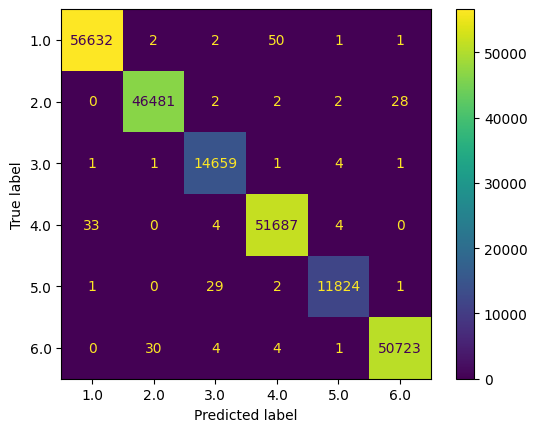

In [24]:
disp.plot()

In [25]:
from sklearn.metrics import accuracy_score

# Train Accuracy
train_accuracy = accuracy_score(y_train, rf.predict(X_train))
print(f"Train Accuracy: {train_accuracy:.4f}")

# Test Accuracy
test_accuracy = accuracy_score(y_test, rf.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 0.9151
Test Accuracy: 0.9153


In [26]:
# Feature Importance
importances = rf_optimal.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:\n", feature_importance_df)

Feature Importance:
         Feature  Importance
3     dry_sales    0.361918
2   fresh_sales    0.303083
1  luxury_sales    0.198177
0   outlet_city    0.136822


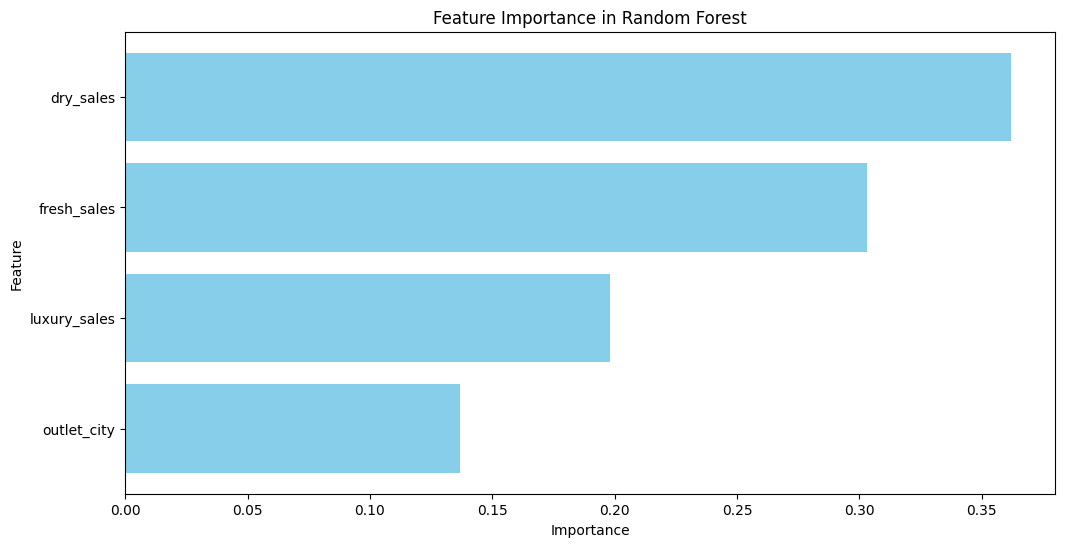

In [27]:
# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [29]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train, y_train,
    cv=3,  # Reduce folds to 3 (faster)
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),  # Reduce points to 5
    n_jobs=-1  # Use all CPU cores for parallel processing
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

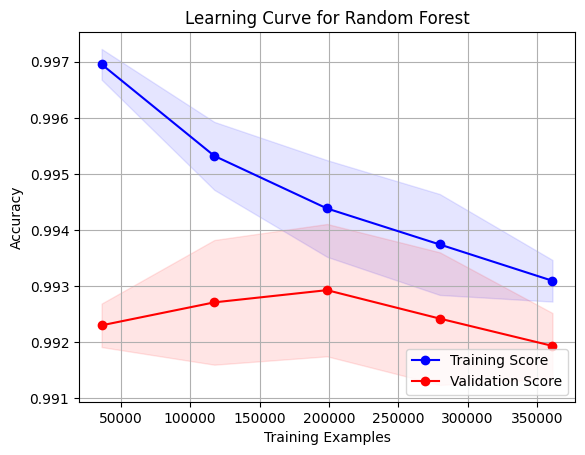

In [30]:
# Plot training accuracy
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
# Plot validation accuracy
plt.plot(train_sizes, test_mean, 'o-', color="red", label="Validation Score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="red")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_test, classes=[0,1,2,3,4,5])  # Binarizing the target variable
y_pred_prob=rf_best.predict_proba(X_test)

In [32]:
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve for each class
for i in range (len(rf_cm)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


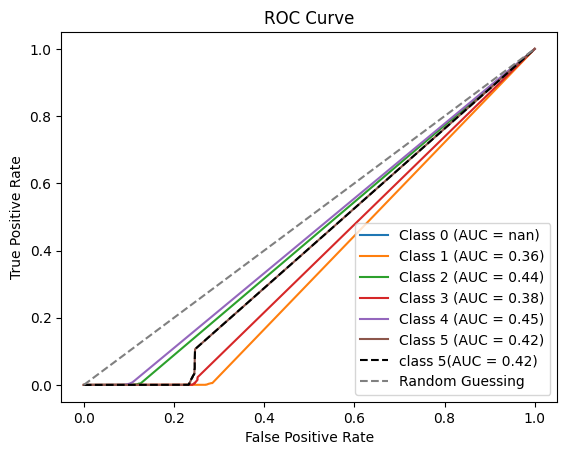

In [33]:
# Plot each class ROC curve
for i in range(len(rf_cm)):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot macro-average ROC curve
plt.plot(fpr[i], tpr[i], linestyle="--", color="black", label=f'class {i}(AUC = {roc_auc[i]:.2f})')

# Plot chance level (random classifier)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [34]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42) #This is where 'rf' is redefined
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [35]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df.head(10))

        Actual  Predicted
136482     4.0        4.0
466661     1.0        1.0
81511      4.0        4.0
687267     6.0        6.0
377685     1.0        1.0
340981     5.0        3.0
541965     1.0        1.0
99845      4.0        4.0
332401     5.0        5.0
514841     1.0        1.0


In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Model Accuracy: {accuracy:.4f}")

Overall Model Accuracy: 0.9906
